In [ ]:
import zipfile
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers

dev = tf.test.gpu_device_name()
print("Device: ",dev)
tf.device('/device:GPU:0')
train_data = pd.read_csv("/content/fashion-mnist_train.csv")
display(train_data.head(4))

#Function to adjust labels to search for specific items
def filterForX(x):
  #X = 0 #T-shirt/top
  #X = 1 #Trouser
  #X = 2 #Pullover
  #X = 3 #Dress
  #X = 4 #Coat
  #X = 5 #Sandal
  #X = 6 #Shirt
  #X = 7 #Sneaker
  #X = 8 #Bag
  X = 9 #Ankle boot
  if x == X:
    return 1
  else: return -1

train_images = train_data.iloc[:, 1:]
train_labels = train_data.label#.map(lambda x: filterForX(x) )
train_images = np.array(train_images)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

Device:  /device:GPU:0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
display(train_dataset)


<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
#Generator taken from the Tensorflow Deep Convolutional Generative Adversarial NN tutorial

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

display(generated_image.shape)

TensorShape([1, 28, 28, 1])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.00154001]], shape=(1, 1), dtype=float32)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = 'content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


NameError: ignored

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


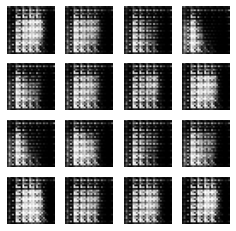

Time for epoch 1 is 13.601988315582275 sec


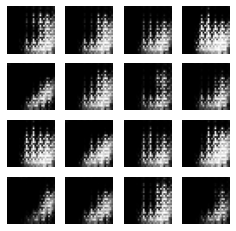

Time for epoch 2 is 11.913947343826294 sec


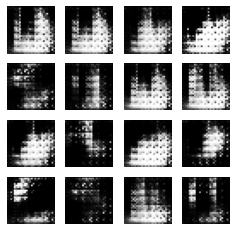

Time for epoch 3 is 11.625653743743896 sec


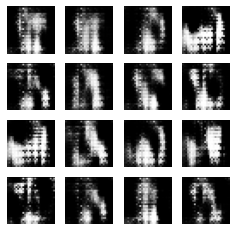

Time for epoch 4 is 11.235337018966675 sec


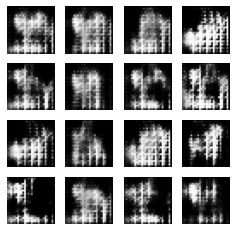

Time for epoch 5 is 11.172694683074951 sec


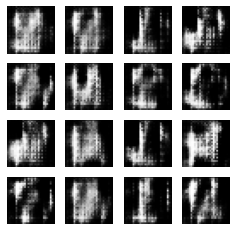

Time for epoch 6 is 11.37416934967041 sec


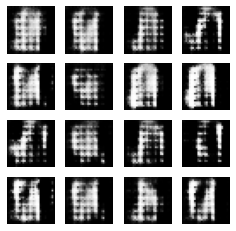

Time for epoch 7 is 11.267448425292969 sec


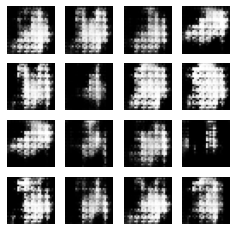

Time for epoch 8 is 11.367524147033691 sec


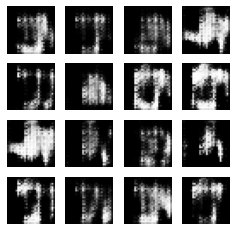

Time for epoch 9 is 11.465209245681763 sec


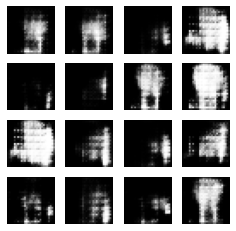

Time for epoch 10 is 11.55172848701477 sec


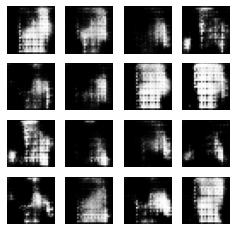

Time for epoch 11 is 11.310292959213257 sec


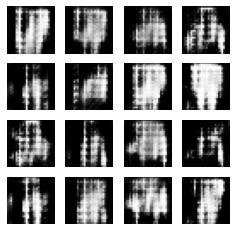

Time for epoch 12 is 11.264826774597168 sec


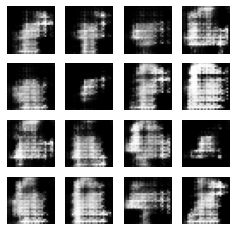

Time for epoch 13 is 11.428030729293823 sec


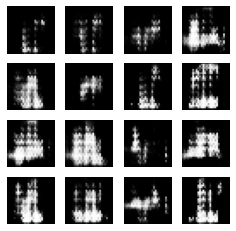

Time for epoch 14 is 11.264641523361206 sec


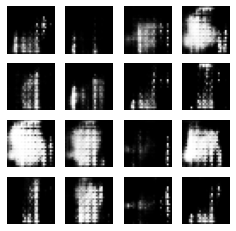

Time for epoch 15 is 11.556511402130127 sec


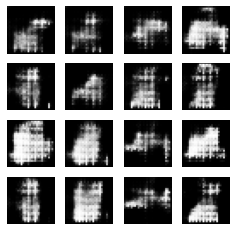

Time for epoch 16 is 11.289795875549316 sec


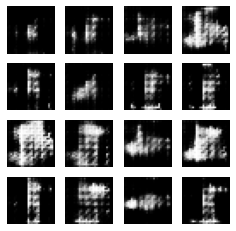

Time for epoch 17 is 11.342718839645386 sec


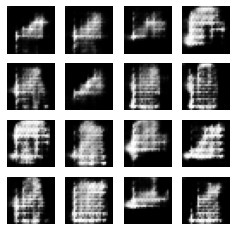

Time for epoch 18 is 11.317595481872559 sec


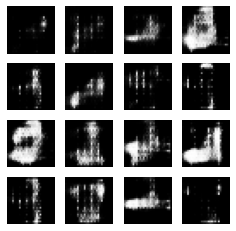

Time for epoch 19 is 11.429676294326782 sec


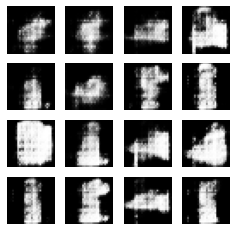

Time for epoch 20 is 11.289347887039185 sec


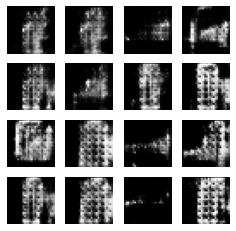

Time for epoch 21 is 11.317065954208374 sec


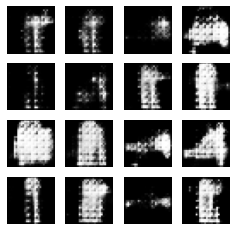

Time for epoch 22 is 11.427655458450317 sec


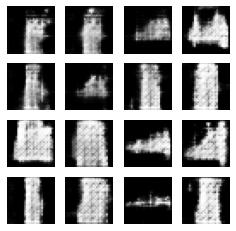

Time for epoch 23 is 11.321685552597046 sec


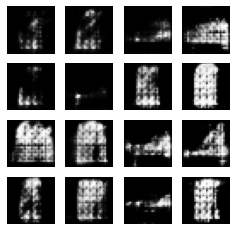

Time for epoch 24 is 11.31234335899353 sec


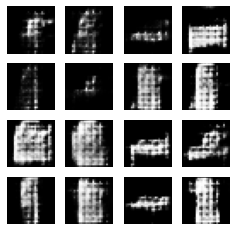

Time for epoch 25 is 11.430991649627686 sec


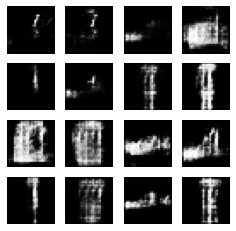

Time for epoch 26 is 11.295045852661133 sec


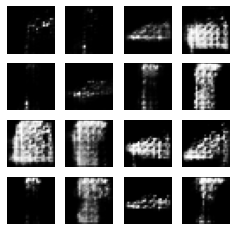

Time for epoch 27 is 11.296173810958862 sec


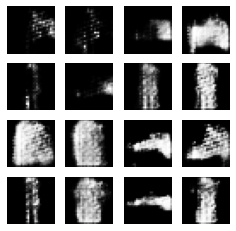

Time for epoch 28 is 11.41347360610962 sec


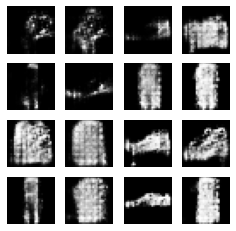

Time for epoch 29 is 11.277286529541016 sec


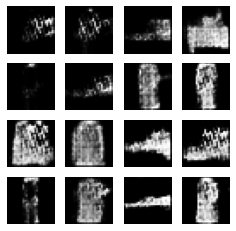

Time for epoch 30 is 11.545206308364868 sec


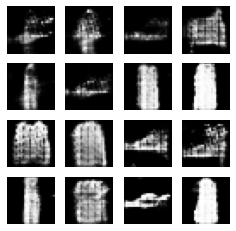

Time for epoch 31 is 11.289691686630249 sec


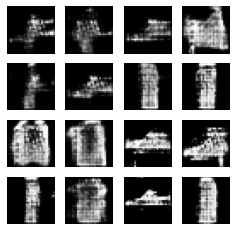

Time for epoch 32 is 11.295169830322266 sec


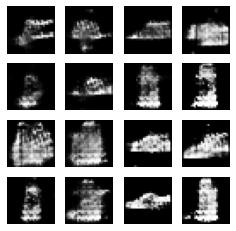

Time for epoch 33 is 11.282037734985352 sec


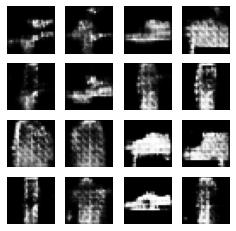

Time for epoch 34 is 11.441214799880981 sec


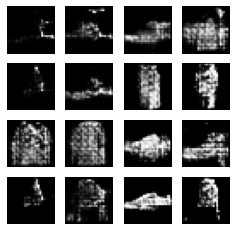

Time for epoch 35 is 11.291272640228271 sec


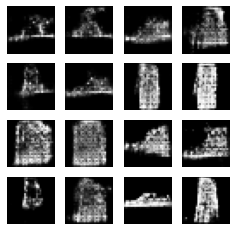

Time for epoch 36 is 11.283531665802002 sec


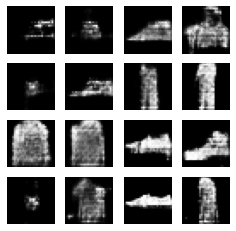

Time for epoch 37 is 11.414355278015137 sec


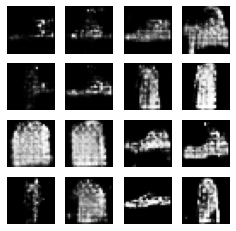

Time for epoch 38 is 11.270326614379883 sec


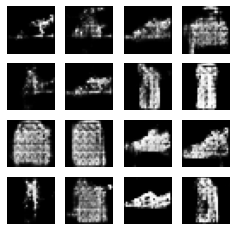

Time for epoch 39 is 11.246259450912476 sec


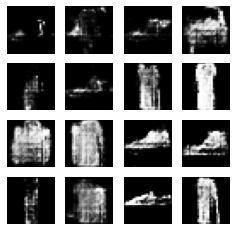

Time for epoch 40 is 11.392799615859985 sec


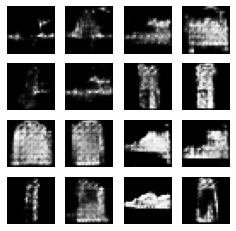

Time for epoch 41 is 11.244077920913696 sec


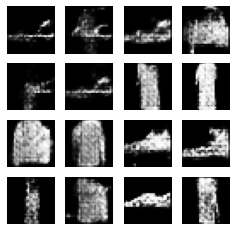

Time for epoch 42 is 11.246601581573486 sec


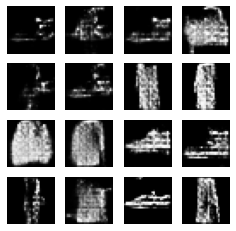

Time for epoch 43 is 11.377415418624878 sec


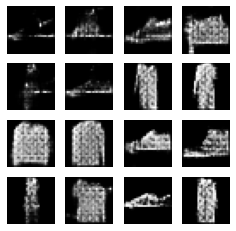

Time for epoch 44 is 11.27000379562378 sec


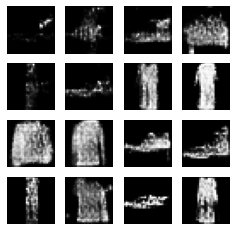

Time for epoch 45 is 11.478792428970337 sec


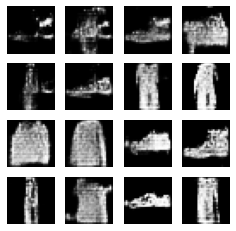

Time for epoch 46 is 11.242586374282837 sec


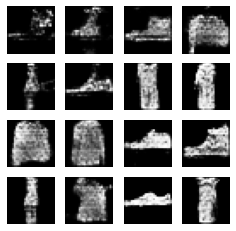

Time for epoch 47 is 11.290956497192383 sec


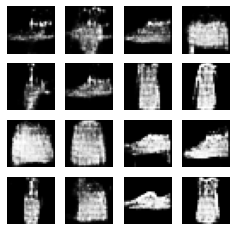

Time for epoch 48 is 11.286895275115967 sec


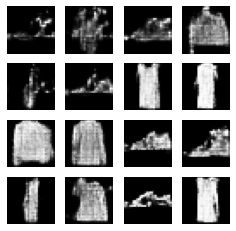

Time for epoch 49 is 11.421629905700684 sec


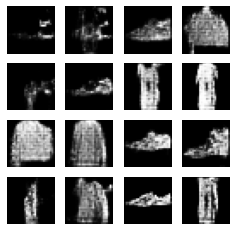

Time for epoch 50 is 11.335528135299683 sec


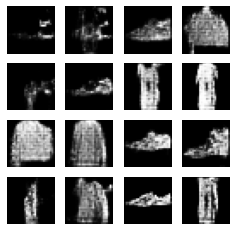

In [ ]:
train(train_dataset, EPOCHS)


In [ ]:
#Restore latest checkpoint
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


# Classifier

In [ ]:
def make_classifier_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(10))


    return model

def classifier_loss(input_label, prediction):
    cat_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = cat_cross_entropy(input_label, prediction)
    return loss

In [ ]:
@tf.function
def class_train_step(images, label):
    
    with tf.GradientTape() as class_tape:
      pred_label = classifier(images, training=True)
      
      class_loss = classifier_loss(label, pred_label)

    gradients_of_classifier = class_tape.gradient(class_loss, classifier.trainable_variables)

    classifier_optimizer.apply_gradients(zip(gradients_of_classifier, classifier.trainable_variables))


def train_class(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      #print(label_batch.shape)
      #display(image_batch)
      class_train_step(image_batch, label_batch)


def evaluate_class(images, labels):
  count = 0
  right = classifier(images, training=False)
  for i in range(len(right)):
    #print(np.argmax(right[i]))
    if np.argmax(right[i]) == labels[i]:
      count = count + 1
  return count/len(images)

def evaluate_adv_class(images, labels, epsilon=0.01):
  images = images.numpy()
  for i in range(len(images)):
    grad = create_adversarial_pattern(images[i], labels[i])
    images[i] = np.clip(images[i] + (images[i]>-1)*epsilon*grad, -1, 1)
  images = tf.convert_to_tensor(images)
  return evaluate_class(images,labels)

In [ ]:
classifier = make_classifier_model()
classifier_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
train_class(train_dataset, EPOCHS)

# Adversarial Network

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
pretrained_model = classifier

def create_adversarial_pattern(input_image, input_label):
  input_image = tf.reshape(input_image,[1,28,28,1])
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
test_data = pd.read_csv("/content/fashion-mnist_test.csv")

test_images = test_data.iloc[:, 1:]
test_images = np.array(test_images)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

test_images = tf.convert_to_tensor(test_images,)
test_labels = test_data.label

#print(np.argmax(classifier(test_images)[482]))
#print(classifier(test_images)[482])
#print(test_labels[482])

#test_loss, test_acc = classifier.evaluate(test_images,  test_labels, verbose=2)

print('\nTrain accuracy:', evaluate_class(train_images, train_labels))

print('\nTest accuracy: ', evaluate_class(test_images,test_labels))

epsilon = 0.05

#adv_images = test_images.map(lambda x: x + (x+1)/2*epsilon*create_adversarial_pattern(x, [[3]]))

print('Test accuracy after Adversarial: ', evaluate_adv_class(test_images,test_labels,epsilon))

eps = [0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
acc = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(len(eps)):
  acc[i] = evaluate_adv_class(test_images, test_labels, eps[i])

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
plt.gca().tick_params(colors='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel("Epsilon", color='white')
plt.ylabel("Accuracy", color='white')


plt.plot(eps,acc)
plt.show()

ResourceExhaustedError: ignored

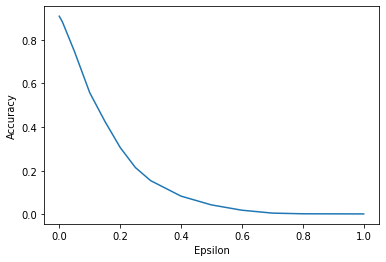

In [ ]:
plt.plot(eps,acc)
plt.xlabel("Epsilon", color='white')
plt.ylabel("Accuracy", color='white')
plt.show()

4196


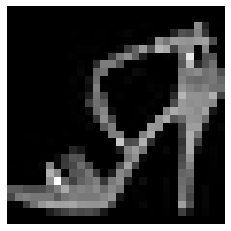

True label:  5
Classifier Label:  tf.Tensor(
[[-2.9252849  -9.743571   -1.9936254  -3.5566578  -8.485764   12.214063
  -3.2969184  -2.3577685   0.30252576  1.279185  ]], shape=(1, 10), dtype=float32)
Classifier Label after Adversarial 2.0:  tf.Tensor(
[[-2.8801136 -8.738494  -1.9541582 -2.6174803 -7.9563913  5.1463337
  -3.157663  -1.432003   1.1322485  5.206911 ]], shape=(1, 10), dtype=float32)


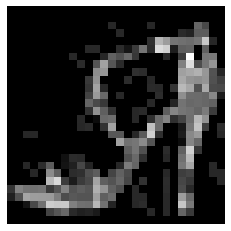

In [ ]:
#test_image = generator(tf.random.normal([1,noise_dim]), training=False)
test_data = pd.read_csv("/content/fashion-mnist_test.csv")
#boot = [test_data.label == 3]
index = np.random.choice(np.arange(10000))#[boot])
print(index)

test_image = test_data.iloc[index, 1:]
test_image = np.array(test_image)
test_image = test_image.reshape(1, 28, 28, 1).astype('float32')
test_image = (test_image - 127.5) / 127.5 # Normalize the images to [-1, 1]

test_image = tf.convert_to_tensor(test_image,)
test_labels = test_data.label

plt.imshow(test_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()

EP = 0.3
label = classifier(test_image, training=False)
print("True label: ",test_labels[index])
print("Classifier Label: ",label)
grad = create_adversarial_pattern(test_image, test_labels[index])#[[3]])
ad_image = test_image + EP*grad
ad_label = classifier(ad_image, training=False)
#print("Classifier Label after Adversarial: ", ad_label)
test_image = test_image.numpy()
ad2_image = np.clip(test_image + (test_image>-1)*EP*grad, -1, 1)
ad2_image = tf.convert_to_tensor(ad2_image)
ad2_label = classifier(ad2_image, training=False)
print("Classifier Label after Adversarial 2.0: ", ad2_label)

#plt.imshow(ad_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
#plt.axis('off')
#plt.show()
plt.imshow(ad2_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
#generator.summary()
#discriminator.summary()
classifier.summary()